# 建立 Tensorflow Model Transfer
# (1) 建立 CNN 手寫辨識系統與儲存模組

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

Loading MNIST DataBase
 -------------------------------------------
 train number= 55000 
 vakidation number= 5000 
 test number= 10000 
 train image shape (55000, 784) 
 label image shape (55000, 10) 
 train image size 784 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate 

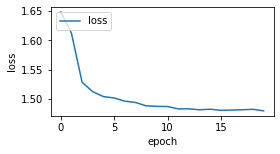

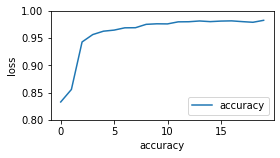

Predict Neural Network 
 -------------------------------------------



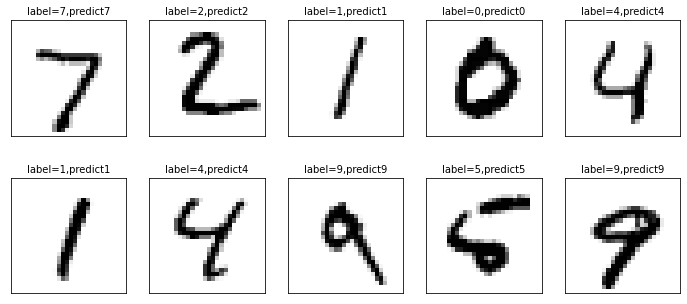

In [1]:
#Tensorflow 
# 手寫識別
# https://www.tensorflow.org/api_docs/python/tf?hl=zh-tw
# 查詢 mnist 函式
#---------------------------------------------------------------------------------------------------------------
import tensorflow as tf
import numpy as np 
from time import time
from tensorflow.examples.tutorials.mnist import input_data
#import tensorflow.examples.tutorials.mnist.input_data as input_data

# 讀取 手寫識別資料庫
#---------------------------------------------------------------------------------------------------------------
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
print('\nLoading MNIST DataBase\n',
      '-------------------------------------------\n',
      'train number=',mnist.train.num_examples,"\n",
      'vakidation number=',mnist.validation.num_examples,"\n",
      'test number=',mnist.test.num_examples,"\n",
      'train image shape', mnist.train.images.shape,"\n",
      'label image shape', mnist.train.labels.shape,"\n",
      'train image size' , mnist.train.images[0].size,"\n")


# 建立 讀影像函數
#---------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
img_w = 28;img_h = 28
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf() # 開畫布
    fig.set_size_inches(12,14)
    if num>25 : num=25
    for i in range(0,num):
        ax = plt.subplot(5,5,1+i)
        ax.imshow(np.reshape(images[idx],(img_w,img_h)),cmap='binary')
        title = "label="+str(np.argmax(labels[idx]))
        if len(prediction)>0:
            title+=",predict"+str(prediction[idx])
            
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx+=1
    plt.show()

def show_images_labels_predict_error(images,labels,prediction_result):
    fig = plt.gcf()
    fig.set_size_inches(8, 10)
    i=0;j=0
    while i<10:
        if prediction_result[j]!=np.argmax(labels[j]):
            ax=plt.subplot(5,5, 1+i)
            ax.imshow(np.reshape(images[j],(28, 28)), 
                      cmap='binary')
            ax.set_title("j="+str(j)+
                         ",l=" +str(np.argmax(labels[j]))+
                         ",p="+str(prediction_result[j])
                         ,fontsize=9) 
            i=i+1  
        j=j+1
    plt.show()    

    
# 建立 卷積神經網路(靜置圖)
#---------------------------------------------------------------------------------------------------------------
def weight(shape): return tf.Variable(tf.truncated_normal(shape, stddev=0.1),name ='W') #variable
def bias(shape): return tf.Variable(tf.constant(0.1, shape=shape), name = 'b') #vaiable
def conv2d(x, W): return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME') #convolution 2x2
def max_pool_2x2(x):return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#input layer
x = tf.placeholder("float",shape=[None, 784] ,name="x")    
x_image = tf.reshape(x, [-1, 28, 28, 1])

#convolution layer 1
W1 = weight([5,5,1,16]) # filter size is 5x5, image number: 1 ->16
b1 = bias([16])
Conv1=conv2d(x_image, W1)+ b1
C1_Conv = tf.nn.relu(Conv1 )
C1_Pool = max_pool_2x2(C1_Conv) #[14,14]

#convolution layer 2
W2 = weight([5,5,16,36]) # filter size is 5x5, image number: 16 -> 36  
b2 = bias([36])
Conv2=conv2d(C1_Pool, W2)+ b2
C2_Conv = tf.nn.relu(Conv2)
C2_Pool = max_pool_2x2(C2_Conv) #[7,7]

#fully connnected layer, Start Netual Network!!
C2_dim = 7*7*36
flat = tf.reshape(C2_Pool, [-1, C2_dim])

#hidden layer
W3 = weight([C2_dim, 128])
b3 = bias([128])
h1 = tf.nn.relu(tf.matmul(flat, W3)+b3)
h1_dropout = tf.nn.dropout(h1, keep_prob=0.8)

#output
W4 = weight([128,10])
b4 = bias([10])
y_predict= tf.nn.softmax(tf.matmul(h1_dropout,W4)+b4,  axis=None, name="prediction")

#optimizer
learning= 0.0001
y_label = tf.placeholder("float", shape=[None, 10], name="y_label")
loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict , labels=y_label))
optimizer = tf.train.AdamOptimizer(learning_rate=learning).minimize(loss_function)

#evaluate_model
correct_prediction = tf.equal(tf.argmax(y_predict, 1),tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


# 建立 卷積神經網路(訓練模型)
#---------------------------------------------------------------------------------------------------------------
from tensorflow.python.framework import graph_util
from tensorflow.python.platform import gfile
def train_model(trainEpochNum=20,batchSizeNum=100) :
    trainEpochs = trainEpochNum
    batchSize = batchSizeNum
    totalBatchs = int(mnist.train.num_examples/batchSize)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    startTime=time()

    for epoch in range(trainEpochs):
        for i in range(totalBatchs):
            batch_x, batch_y = mnist.train.next_batch(batchSize)
            sess.run(optimizer,feed_dict={x: batch_x,y_label: batch_y})

        loss,acc = sess.run([loss_function,accuracy],feed_dict={x: mnist.validation.images, y_label: mnist.validation.labels})
        epoch_list.append(epoch)
        loss_list.append(loss);accuracy_list.append(acc)    
        print("Train Epoch:", '%02d' % (epoch+1), "Loss=","{:.9f}".format(loss)," Accuracy=",acc)

    duration =time()-startTime
    print("Train Finished takes:",duration) 
    
    #save_model
    graph_def = tf.get_default_graph().as_graph_def()
    output_graph_def = graph_util.convert_variables_to_constants(sess,graph_def, ['prediction'])
    with tf.gfile.GFile('model.pb', 'wb') as fid:
        serialized_graph = output_graph_def.SerializeToString()
        fid.write(serialized_graph)
    print("Model saved in file: %s" % 'model.pb')
        
    return sess

    
epoch_list=[];
accuracy_list=[];
loss_list=[];
sess = train_model()

# 繪製結果
#---------------------------------------------------------------------------------------------------------------
def plot_loss_function(epoch_list, loss_list):
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.gcf()
    fig.set_size_inches(4,2)
    plt.plot(epoch_list,loss_list,label='loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss'],loc='upper left')
    plt.show()

def plot_accuracy( epoch_list, accuracy_list):
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.gcf()
    fig.set_size_inches(4,2)
    plt.plot(epoch_list,accuracy_list,label='accuracy')
    plt.ylim(0.8,1)
    plt.ylabel('loss')
    plt.xlabel('accuracy')
    plt.legend()
    plt.show()

plot_loss_function(epoch_list, loss_list)
plot_accuracy(epoch_list, accuracy_list)

#預測
#---------------------------------------------------------------------------------------------------------------
print('Predict Neural Network \n',
      '-------------------------------------------\n')
prediction_result=sess.run(tf.argmax(y_predict,1),feed_dict={x: mnist.test.images ,y_label: mnist.test.labels})
plot_images_labels_prediction(mnist.test.images, mnist.test.labels,prediction_result,0) #顯示前 10 筆

### 儲存  Model

In [2]:
# Saving Model (.ckpt)
#-------------------------------------------------------------------------
def save_Saver(FileName):
    saver = tf.train.Saver()
    save_path = saver.save(sess, FileName)
    print("Saver saved in file: %s" % save_path)
    
save_Saver("saveModel/CNN_model1")

Save 
 -------------------------------------------

Saver saved in file: saveModel/CNN_model1


In [4]:
# Saving Model (.pb)
#-------------------------------------------------------------------------
from tensorflow.python.saved_model import tag_constants
saved_model_dir = "saveModel/CNN_model1"
builder = tf.saved_model.builder.SavedModelBuilder(saved_model_dir)
input  = {'inputs_x':tf.saved_model.utils.build_tensor_info(x)}
output = {'outputs_y':tf.saved_model.utils.build_tensor_info(y_predict)}
signature = tf.saved_model.signature_def_utils.build_signature_def(input,output,'sig_name')
builder.add_meta_graph_and_variables(sess, ['serve'],{'weilly':signature})
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: saveModel/CNN_model1\saved_model.pb


b'saveModel/CNN_model1\\saved_model.pb'

### 查看模組架構

In [5]:
import tensorflow as tf
import pprint
checkpoint_file = "D:\Python\Tensorflow\saveModel\CNN_model1"
NewCheck = tf.train.NewCheckpointReader(checkpoint_file)
pprint.pprint(NewCheck.debug_string().decode("utf-8"))

('W (DT_FLOAT) [5,5,1,16]\n'
 'W/Adam (DT_FLOAT) [5,5,1,16]\n'
 'W/Adam_1 (DT_FLOAT) [5,5,1,16]\n'
 'W_1 (DT_FLOAT) [5,5,16,36]\n'
 'W_1/Adam (DT_FLOAT) [5,5,16,36]\n'
 'W_1/Adam_1 (DT_FLOAT) [5,5,16,36]\n'
 'W_2 (DT_FLOAT) [1764,128]\n'
 'W_2/Adam (DT_FLOAT) [1764,128]\n'
 'W_2/Adam_1 (DT_FLOAT) [1764,128]\n'
 'W_3 (DT_FLOAT) [128,10]\n'
 'W_3/Adam (DT_FLOAT) [128,10]\n'
 'W_3/Adam_1 (DT_FLOAT) [128,10]\n'
 'b (DT_FLOAT) [16]\n'
 'b/Adam (DT_FLOAT) [16]\n'
 'b/Adam_1 (DT_FLOAT) [16]\n'
 'b_1 (DT_FLOAT) [36]\n'
 'b_1/Adam (DT_FLOAT) [36]\n'
 'b_1/Adam_1 (DT_FLOAT) [36]\n'
 'b_2 (DT_FLOAT) [128]\n'
 'b_2/Adam (DT_FLOAT) [128]\n'
 'b_2/Adam_1 (DT_FLOAT) [128]\n'
 'b_3 (DT_FLOAT) [10]\n'
 'b_3/Adam (DT_FLOAT) [10]\n'
 'b_3/Adam_1 (DT_FLOAT) [10]\n'
 'beta1_power (DT_FLOAT) []\n'
 'beta2_power (DT_FLOAT) []\n')


In [4]:
import tensorflow as tf
tf.reset_default_graph()
tf.train.import_meta_graph('D:\Python\Tensorflow\saveModel\CNN_model1.meta')
for n in tf.get_default_graph().as_graph_def().node:
    print(n)

name: "x"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: -1
      }
      dim {
        size: 784
      }
    }
  }
}

name: "Reshape/shape"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
        dim {
          size: 4
        }
      }
      tensor_content: "\377\377\377\377\034\000\000\000\034\000\000\000\001\000\000\000"
    }
  }
}

name: "Reshape"
op: "Reshape"
input: "x"
input: "Reshape/shape"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "Tshape"
  value {
    type: DT_INT32
  }
}

name: "truncated_normal/shape"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
        dim {
          size: 4
        }
      }
      tensor_content: "\005\000\000\00

# (2) 模組轉換

In [21]:
#Tensorflow 
# .ckpt to .pb 
#https://blog.csdn.net/guyuealian/article/details/82218092
#-------------------------------------------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.python.framework import graph_util

def transfer_graph(input_checkpoint, output_pb_path, output_pb_names):
    sess = tf.Session()
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=True)
    
    if(input_checkpoint[len(input_checkpoint)-4:]=='ckpt') :
        saver.restore(sess,tf.train.latest_checkpoint(input_checkpoint)) 
    else:
        saver.restore(sess,input_checkpoint)
        
    tf.train.write_graph(sess.graph_def, output_pb_path, output_pb_names, False) 
        
        
#-------------------------------------------------------------------------------------------------------------
input_checkpoint = "saveModel/CNN_model1"
output_protocolbuffers_path = "saveModel/CNN_model_ckpt2pb/"
output_protocolbuffers_name = "graph_model.pb" 
transfer_graph(input_checkpoint, output_protocolbuffers_path, output_protocolbuffers_name) # ckpt to pb

INFO:tensorflow:Restoring parameters from saveModel/CNN_model1


In [3]:
#Tensorflow 
# .ckpt to .pb (froze)
#https://blog.csdn.net/guyuealian/article/details/82218092
#-------------------------------------------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.python.framework import graph_util

def freeze_graph(input_checkpoint, output_protocolbuffers, output_node_names):
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=True)
    with tf.Session() as sess:
        saver.restore(sess, input_checkpoint)#讀取模組
        output_graph_def = graph_util.convert_variables_to_constants(sess=sess,
                                                                     input_graph_def=sess.graph_def,
                                                                     output_node_names=output_node_names.split(","))
        
        with tf.gfile.GFile(output_protocolbuffers, "wb") as f: #重新儲存模型
            f.write(output_graph_def.SerializeToString()) 
        print("%d ops in the final graph." % len(output_graph_def.node)) 
        #print([node.name for node in sess.graph.as_graph_def().node])# 印出所有 node
        
#-------------------------------------------------------------------------------------------------------------
input_checkpoint = "saveModel/CNN_model1"
output_protocolbuffers = "saveModel/CNN_model_ckpt2pb/froze_graph_model.pb"
output_node_names ="prediction" #ouput_names
freeze_graph(input_checkpoinoutput_protocolbuffers = "saveModel/CNN_model_ckpt2pb/froze_graph_model.pb", 
             output_protocolbuffers, 
             output_node_names) # ckpt to pb

INFO:tensorflow:Restoring parameters from saveModel/CNN_model1
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.
51 ops in the final graph.


In [1]:
#Tensorflow 
# .pb to .pbtxt (不可逆)
#https://blog.csdn.net/yunxinan/article/details/90747586
#https://yinguobing.com/freeze-model-in-tensorflow/
#-------------------------------------------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.python.platform import gfile
from google.protobuf import text_format

def convert_pb_to_pbtxt(input_pb, output_pbtxt_path, output_pbtxt_name):
    with gfile.FastGFile(input_pb, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')
        tf.train.write_graph(graph_def, output_pbtxt_path, output_pbtxt_name, as_text=True)
    return

#-------------------------------------------------------------------------------------------------------------
input_protocolbuffers = "saveModel/CNN_model_ckpt2pb/froze_graph_model.pb"
output_protocolbuffersText = "froze_graph_model.pbtxt"
output_protocolbuffersText_Path = "saveModel/CNN_model_ckpt2pb/"
convert_pb_to_pbtxt(input_protocolbuffers, output_protocolbuffersText_Path, output_protocolbuffersText)

Instructions for updating:
Use tf.gfile.GFile.
